In [45]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import ttest_ind
import scipy.stats as stats
warnings.filterwarnings('ignore')



engine = create_engine(
    "mssql+pyodbc://@DESKTOP-5TNMJ27\SQLEXPRESS/vendor_analysis"
    "?driver=ODBC+Driver+17+for+SQL+Server"
    "&trusted_connection=yes"
)


In [46]:
df = pd.read_sql_query('select * from vendor_sales_summary',engine)

In [47]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
VendorNumber,10692.0,10650.649458,1.875352e+04,2.000000,3951.000000,7153.000000,9552.000000,2.013590e+05
Brand,10692.0,18039.228769,1.266219e+04,58.000000,5793.500000,18761.500000,25514.250000,9.063100e+04
PurchasePrice,10692.0,24.385303,1.092694e+02,0.360000,6.840000,10.455000,19.482500,5.681810e+03
ActualPrice,10692.0,35.643671,1.482460e+02,0.490000,10.990000,15.990000,28.990000,7.499990e+03
Volume,10692.0,265550.348672,1.069263e+06,0.000000,2250.000000,13500.000000,114750.000000,2.484000e+07
TotalPurchaseQuantity,10692.0,3140.886831,1.109509e+04,1.000000,36.000000,262.000000,1975.750000,3.376600e+05
TotalPurchaseDollars,10692.0,30106.693372,1.230678e+05,0.710000,453.457500,3655.465000,20738.245000,3.811252e+06
TotalSalesQuantity,10692.0,3077.482136,1.095285e+04,0.000000,33.000000,261.000000,1929.250000,3.349390e+05
TotalSalesDollars,10692.0,42239.074419,1.676553e+05,0.000000,729.220000,5298.045000,28396.915000,5.101920e+06
TotalSalesPrice,10692.0,18793.783627,4.495277e+04,0.000000,289.710000,2857.800000,16059.562500,6.728193e+05


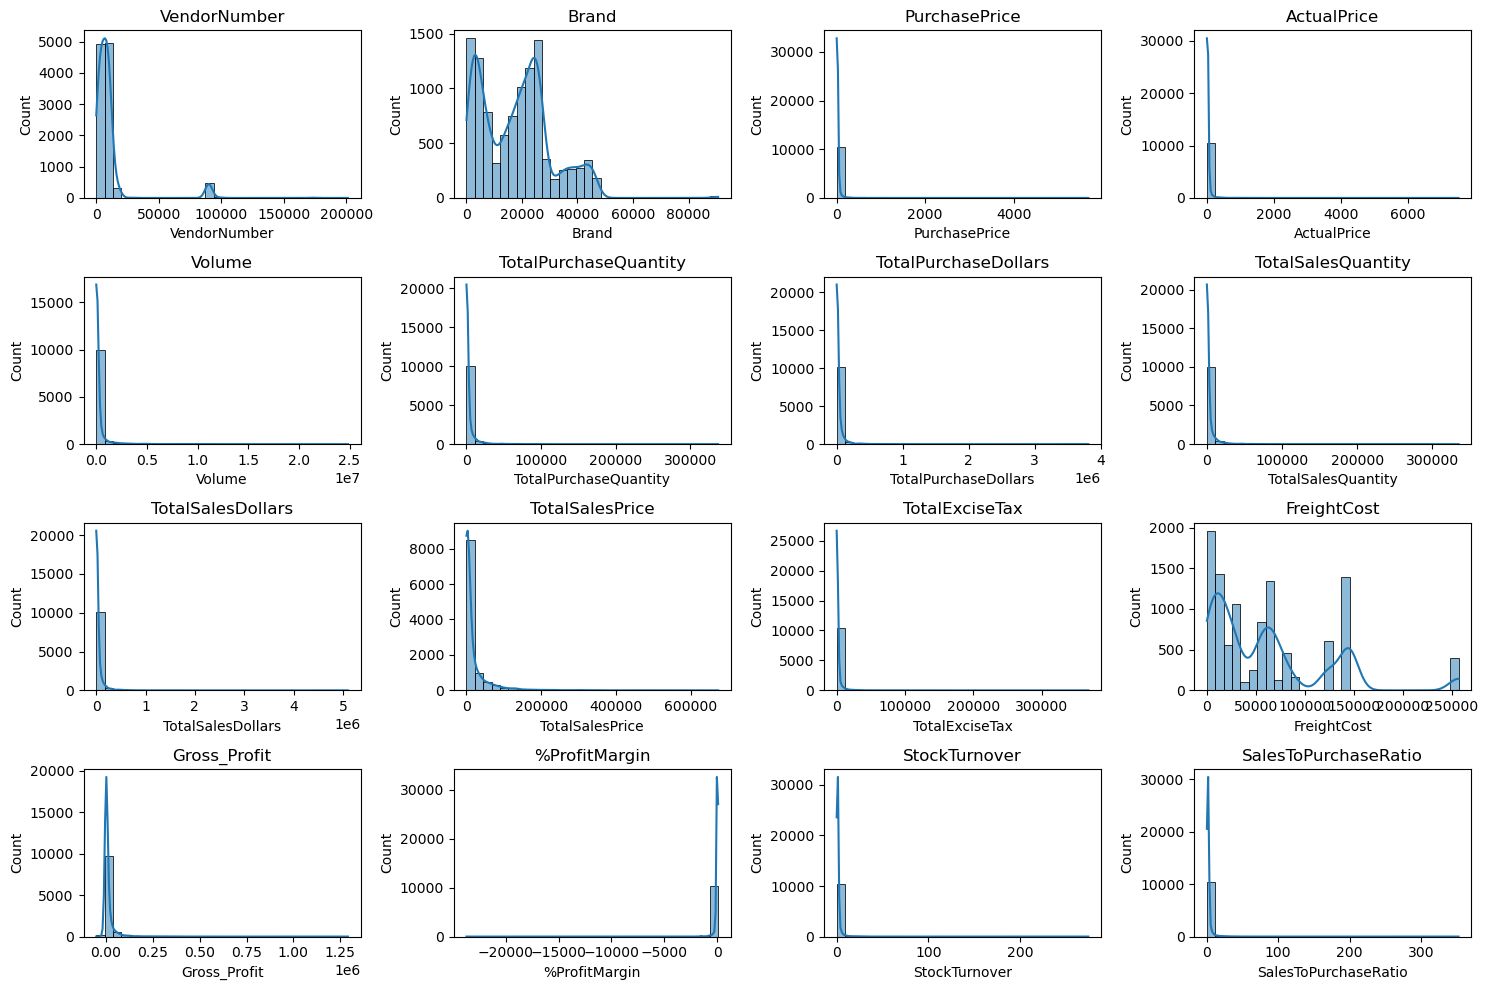

In [48]:
#Distibution Plots for numerical columns

numberical_col = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(numberical_col):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col], kde=True,bins=30)
    plt.title(col)
plt.tight_layout()
plt.show() 

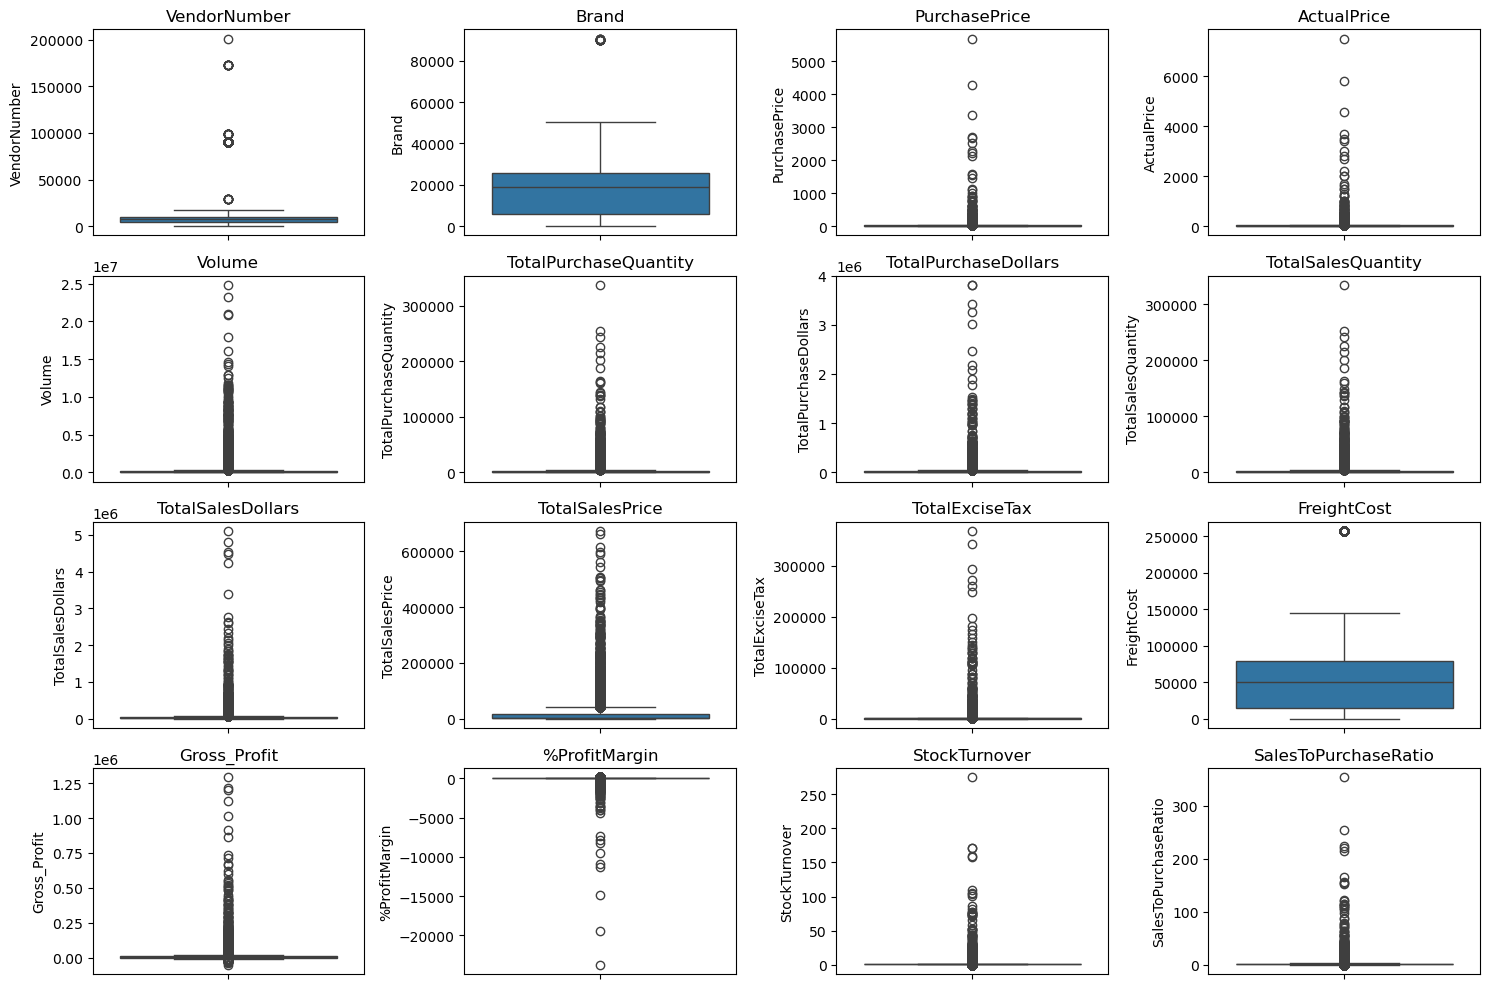

In [49]:
numberical_col = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(numberical_col):
    plt.subplot(4,4,i+1)
    sns.boxplot(df[col])
    plt.title(col)
plt.tight_layout()
plt.show() 

In [50]:
df = pd.read_sql("""select * from vendor_sales_summary 
where Gross_profit > 0
and [%ProfitMargin] > 0
and TotalSalesQuantity >0 """, engine)

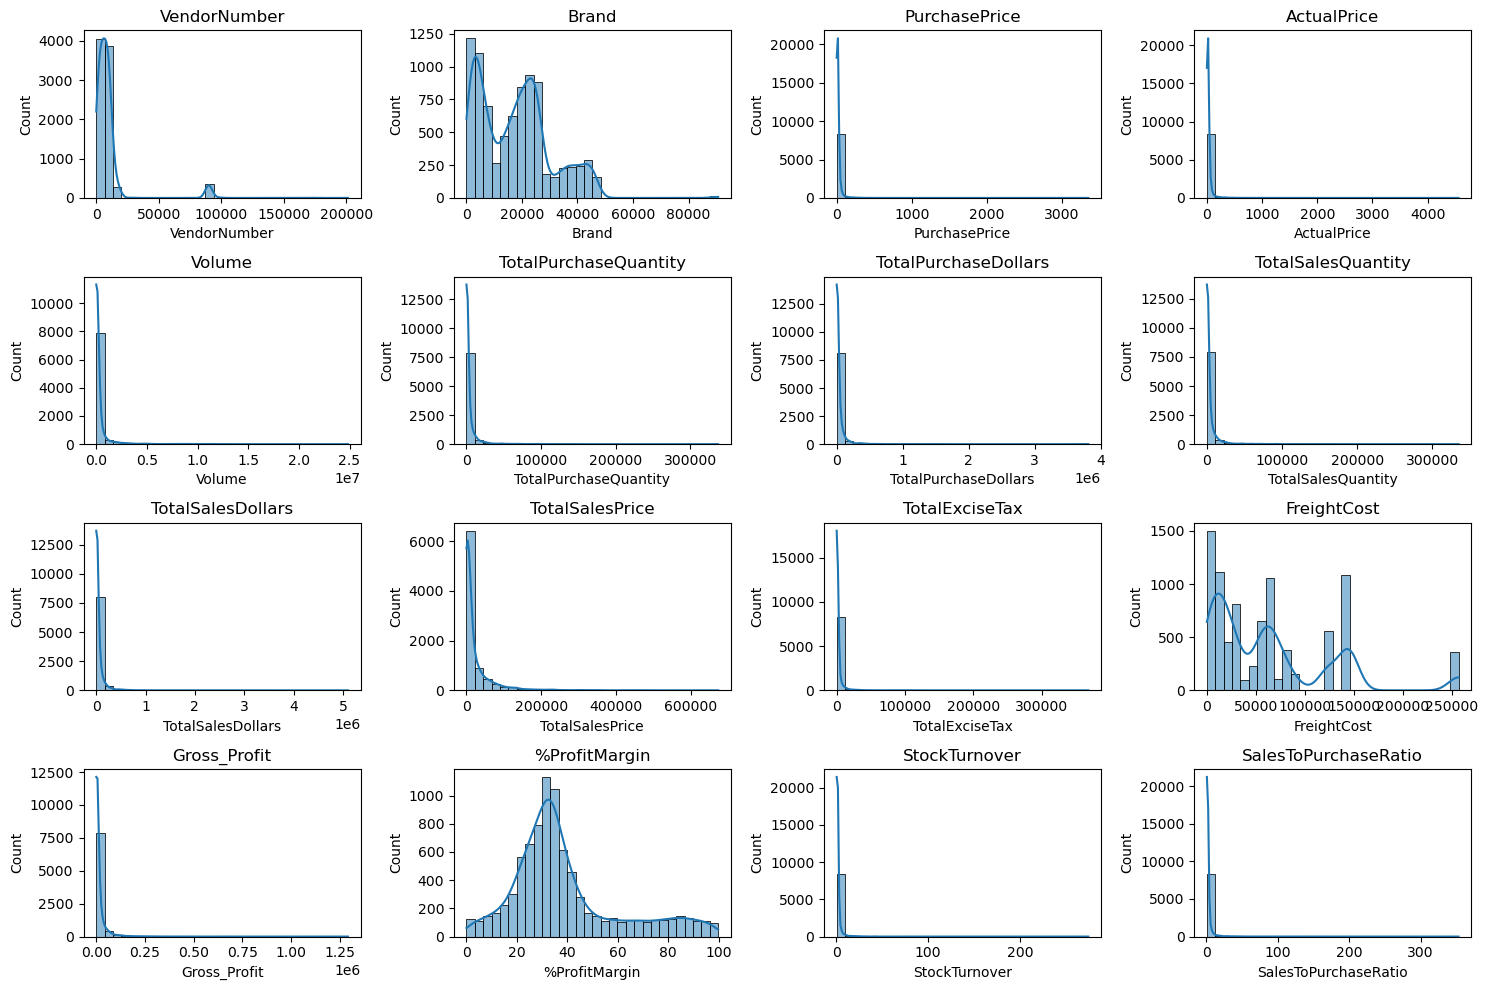

In [51]:
numberical_col = df.select_dtypes(include=np.number).columns

plt.figure(figsize=(15,10))
for i, col in enumerate(numberical_col):
    plt.subplot(4,4,i+1)
    sns.histplot(df[col], kde=True,bins=30)
    plt.title(col)
plt.tight_layout()
plt.show() 

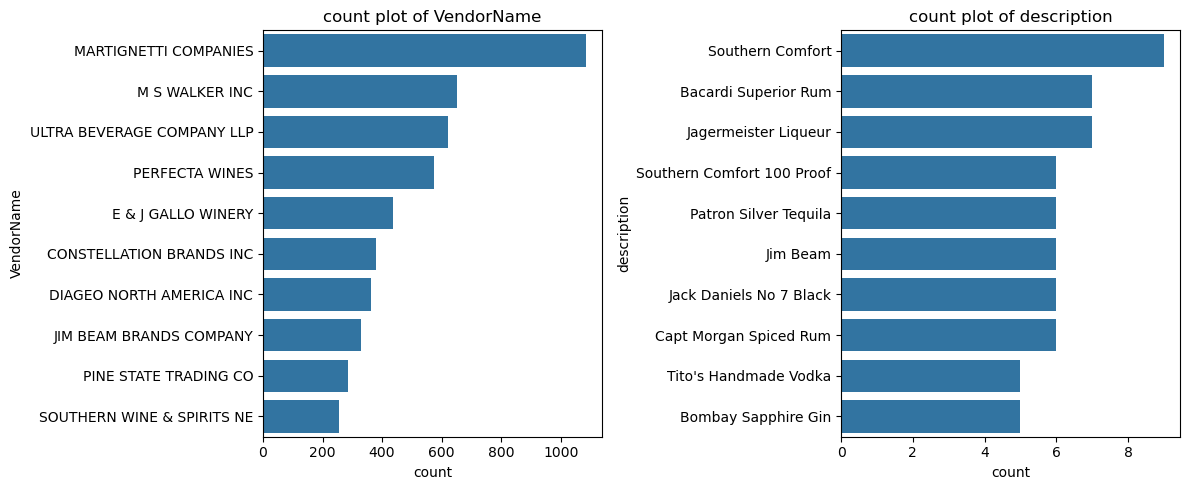

In [52]:
categorical_col = ["VendorName","description"]
plt.figure(figsize=(12,5))
for i, col in enumerate(categorical_col):
    plt.subplot(1,2,i+1)
    sns.countplot(y=df[col],order=df[col].value_counts().index[:10])
    plt.title(f'count plot of {col}')
plt.tight_layout()
plt.show()


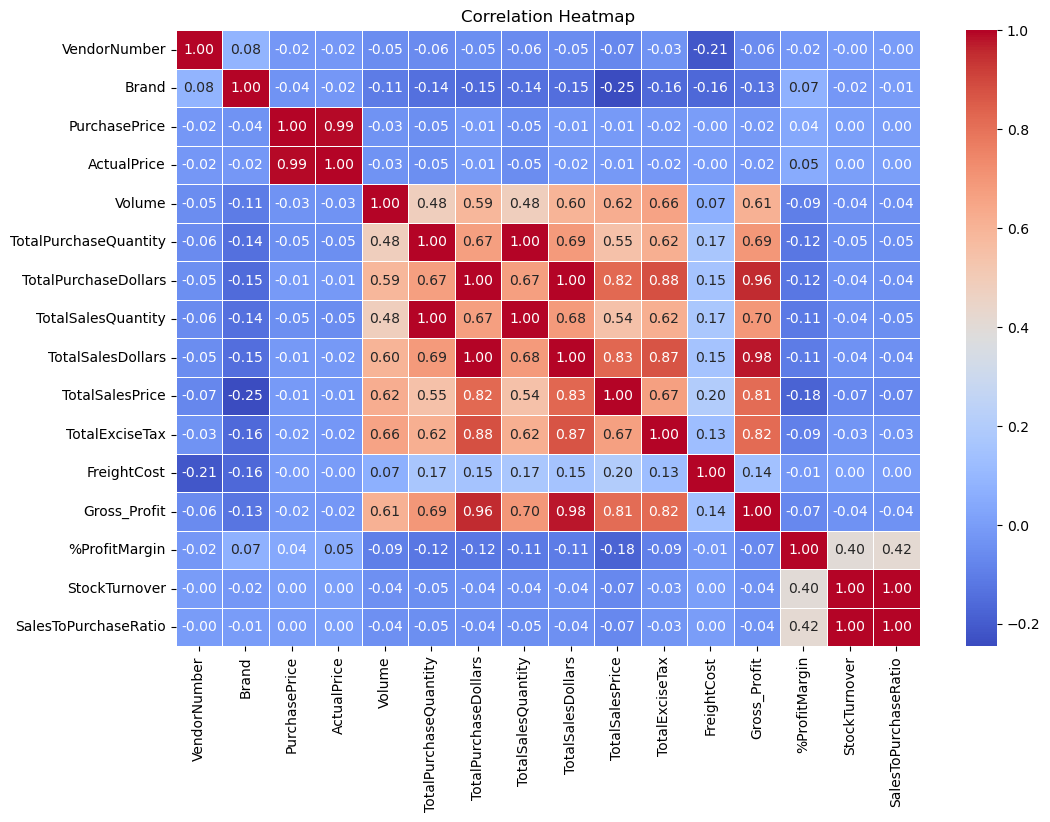

In [53]:
#correlation

plt.figure(figsize=(12,8))
correlation_matrix  = df[numberical_col].corr()
sns.heatmap(correlation_matrix,annot=True,fmt=".2f",cmap="coolwarm",linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

In [86]:
brand_performance = df.groupby('description').agg(
    {
        'TotalSalesDollars':'sum',
        '%ProfitMargin':'mean'
    }
).reset_index()
brand_performance = brand_performance[brand_performance["TotalSalesDollars"] <10000]
brand_performance.describe()

,TotalSalesDollars,%ProfitMargin
count,4162.000000,4162.000000
mean,2691.168328,44.215355
std,2751.695491,25.587351
min,4.990000,0.020842
25%,494.782500,26.387372
50%,1571.615000,35.067831
75%,4340.707500,65.088399
max,9999.470000,99.604734


In [87]:
low_sales_threshold  = brand_performance['TotalSalesDollars'].quantile(0.15)
high_margin_threshold = brand_performance['%ProfitMargin'].quantile(0.85)


In [88]:
low_sales_threshold


np.float64(263.76)

In [89]:
high_margin_threshold

np.float64(79.554449988222)

In [ ]:
#Brands with low sales and high profit margins
target_brands = brand_performance[
    (brand_performance['TotalSalesDollars']<= low_sales_threshold) &
    (brand_performance['%ProfitMargin']>= high_margin_threshold) 
]
target_brands

,description,TotalSalesDollars,%ProfitMargin
96,Absolut Orient Apple Vodka,119.94,87.652159
183,Alma Negra Gran Almanegra,249.95,86.205241
324,Aresti Pnt Nr Curico Vly,94.81,96.540449
600,Basilica Amaretto,47.45,85.079031
1064,C Y Toro Carmenere Terrunyo,175.92,91.774670
1340,Casa Liliana Good Merlot,142.87,81.829635
1601,Ch La Gordonne Chapelle Rose,167.94,88.740026
1866,Cherry On Top Sweet White,64.95,89.006928
2070,Concannon Glen Ellen Wh Zin,15.95,83.448276
2188,Crown Royal Apple,27.86,89.806174


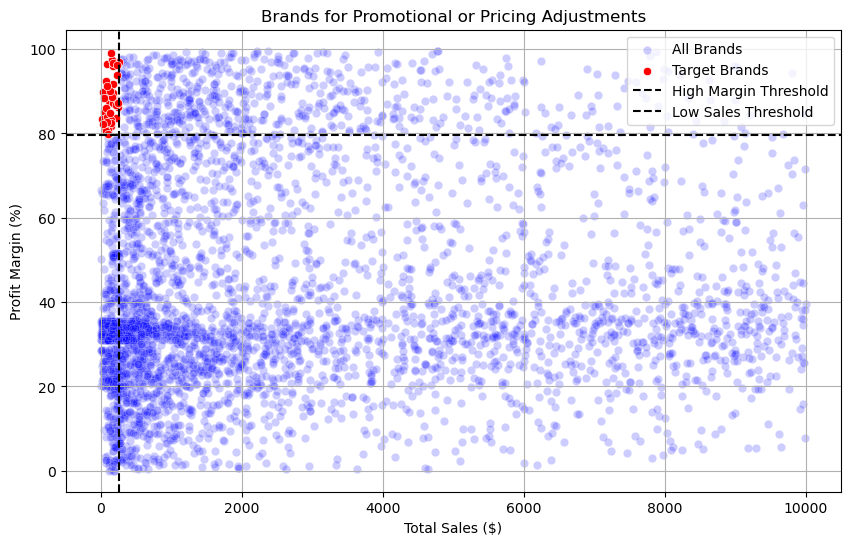

In [91]:
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=brand_performance,
    x='TotalSalesDollars',
    y='%ProfitMargin',
    color='blue',
    label='All Brands',
    alpha=0.2
)

sns.scatterplot(
    data=target_brands,
    x='TotalSalesDollars',
    y='%ProfitMargin',
    color='red',
    label='Target Brands'
)

plt.axhline(
    high_margin_threshold,
    linestyle='--',
    color='black',
    label='High Margin Threshold'
)

plt.axvline(
    low_sales_threshold,
    linestyle='--',
    color='black',
    label='Low Sales Threshold'
)

plt.xlabel('Total Sales ($)')
plt.ylabel('Profit Margin (%)')
plt.title('Brands for Promotional or Pricing Adjustments')

plt.legend()
plt.grid(True)
plt.show()


In [103]:
top_brands = df.groupby(['description','VendorName'])['TotalSalesDollars'].sum().sort_values(ascending=False).head(10)

In [105]:
def format_dollars(value):
    if value >= 1000000:
        return f"{value/1000000:.2f}M"
    elif value >= 1000:
        return f"{value/1000}K"
    else:
        str(value)

In [106]:
top_brands.apply(lambda x : format_dollars(x))

description              VendorName              
Jack Daniels No 7 Black  BROWN-FORMAN CORP           7.96M
Tito's Handmade Vodka    MARTIGNETTI COMPANIES       7.40M
Grey Goose Vodka         BACARDI USA INC             7.21M
Capt Morgan Spiced Rum   DIAGEO NORTH AMERICA INC    6.36M
Absolut 80 Proof         PERNOD RICARD USA           6.24M
Jameson Irish Whiskey    PERNOD RICARD USA           5.72M
Ketel One Vodka          DIAGEO NORTH AMERICA INC    5.07M
Baileys Irish Cream      DIAGEO NORTH AMERICA INC    4.15M
Kahlua                   PERNOD RICARD USA           3.60M
Tanqueray                DIAGEO NORTH AMERICA INC    3.46M
Name: TotalSalesDollars, dtype: object

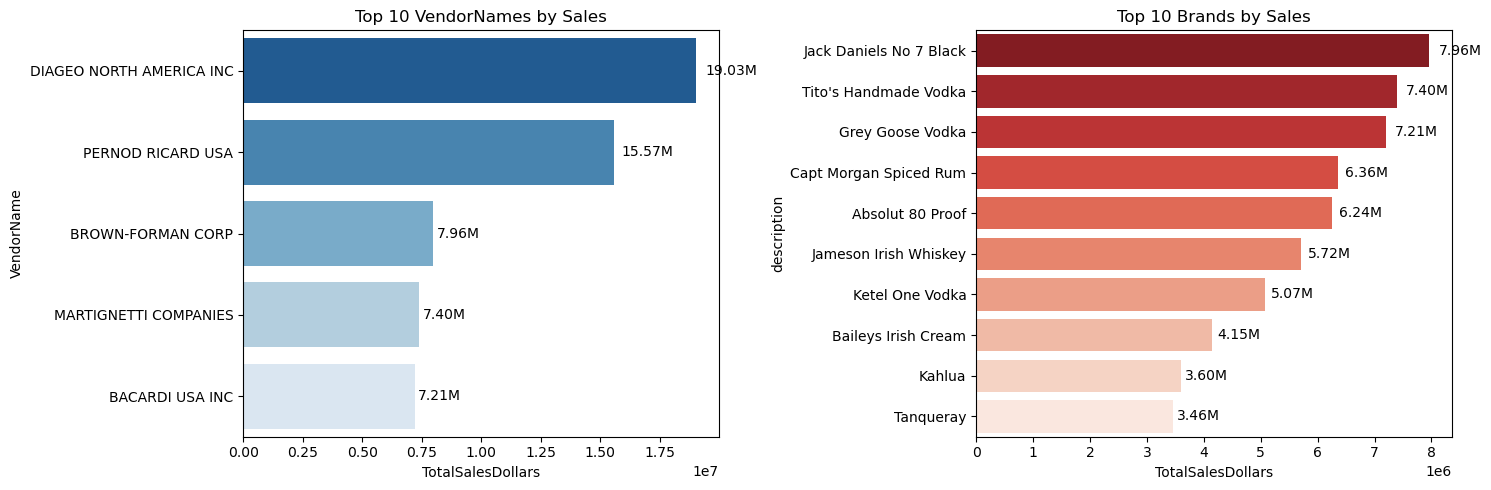

In [120]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Make a clean df from the MultiIndex Series
top_df = top_brands.reset_index()
top_df.columns = ['description', 'VendorName', 'TotalSalesDollars']

# 2) Convert TotalSalesDollars to numeric (handles "7.96M", "500K", etc.)
def parse_money(x):
    x = str(x).strip().upper()
    if x.endswith('M'):
        return float(x[:-1]) * 1_000_000
    if x.endswith('K'):
        return float(x[:-1]) * 1_000
    return float(x.replace(',', ''))

top_df['TotalSalesDollars'] = top_df['TotalSalesDollars'].apply(parse_money)

plt.figure(figsize=(15, 5))

# ------------------- Plot 1: Top VendorNames by Sales -------------------
plt.subplot(1, 2, 1)

top_vendors_df = (top_df.groupby('VendorName', as_index=False)['TotalSalesDollars']
                  .sum()
                  .sort_values('TotalSalesDollars', ascending=False)
                  .head(10))

ax1 = sns.barplot(
    data=top_vendors_df,
    y='VendorName',
    x='TotalSalesDollars',
    palette='Blues_r'
)
plt.title("Top 10 VendorNames by Sales")

for bar in ax1.patches:
    ax1.text(
        bar.get_width() + bar.get_width()*0.02,
        bar.get_y() + bar.get_height()/2,
        format_dollars(bar.get_width()),
        va='center'
    )

# ------------------- Plot 2: Top Brands (Descriptions) by Sales -------------------
plt.subplot(1, 2, 2)

top_desc_df = (top_df.groupby('description', as_index=False)['TotalSalesDollars']
               .sum()
               .sort_values('TotalSalesDollars', ascending=False)
               .head(10))

ax2 = sns.barplot(
    data=top_desc_df,
    y='description',
    x='TotalSalesDollars',
    palette='Reds_r'
)
plt.title("Top 10 Brands by Sales")

for bar in ax2.patches:
    ax2.text(
        bar.get_width() + bar.get_width()*0.02,
        bar.get_y() + bar.get_height()/2,
        format_dollars(bar.get_width()),
        va='center'
    )

plt.tight_layout()
plt.show()


In [166]:
vendor_performance = df.groupby('VendorName')[['TotalPurchaseDollars','Gross_Profit','TotalSalesDollars']].sum().sort_values(by='TotalPurchaseDollars',ascending=False).reset_index()

In [167]:
vendor_performance['ContributionPurchase'] = ((vendor_performance['TotalPurchaseDollars']/vendor_performance['TotalPurchaseDollars'].sum())*100)
round(vendor_performance,2)

,VendorName,TotalPurchaseDollars,Gross_Profit,TotalSalesDollars,ContributionPurchase
0,DIAGEO NORTH AMERICA INC,50097226.16,17892873.26,67990099.42,16.30
1,MARTIGNETTI COMPANIES,25502095.83,13828263.53,39330359.36,8.30
2,PERNOD RICARD USA,23851164.17,8212032.02,32063196.19,7.76
3,JIM BEAM BRANDS COMPANY,23494304.32,7928716.14,31423020.46,7.64
4,BACARDI USA INC,17432020.26,7422796.88,24854817.14,5.67
...,...,...,...,...,...
114,FANTASY FINE WINES CORP,128.64,198.95,327.59,0.00
115,UNCORKED,118.74,58.20,176.94,0.00
116,SILVER MOUNTAIN CIDERS,77.18,265.33,342.51,0.00
117,CAPSTONE INTERNATIONAL,54.64,192.23,246.87,0.00


In [168]:
vendor_performance['TotalPurchaseDollars'] = vendor_performance['TotalPurchaseDollars'].fillna(0).apply(lambda x: format_dollars(x)) 
vendor_performance['Gross_Profit'] = vendor_performance['Gross_Profit'].fillna(0).apply(lambda x: format_dollars(x)) 
vendor_performance['TotalSalesDollars'] = vendor_performance['TotalSalesDollars'].fillna(0).apply(lambda x: format_dollars(x)) 


In [169]:
top_vendors=round(vendor_performance,2).head(10)

In [170]:
top_vendors['ContributionPurchase'].sum()

np.float64(65.69000000000001)

In [171]:
top_vendors['Cumulative'] = top_vendors['ContributionPurchase'].cumsum()
top_vendors

,VendorName,TotalPurchaseDollars,Gross_Profit,TotalSalesDollars,ContributionPurchase,Cumulative
0,DIAGEO NORTH AMERICA INC,50.10M,17.89M,67.99M,16.30,16.30
1,MARTIGNETTI COMPANIES,25.50M,13.83M,39.33M,8.30,24.60
2,PERNOD RICARD USA,23.85M,8.21M,32.06M,7.76,32.36
3,JIM BEAM BRANDS COMPANY,23.49M,7.93M,31.42M,7.64,40.00
4,BACARDI USA INC,17.43M,7.42M,24.85M,5.67,45.67
5,CONSTELLATION BRANDS INC,15.27M,8.95M,24.22M,4.97,50.64
6,BROWN-FORMAN CORP,13.24M,5.01M,18.25M,4.31,54.95
7,E & J GALLO WINERY,12.07M,6.33M,18.40M,3.93,58.88
8,ULTRA BEVERAGE COMPANY LLP,11.17M,5.34M,16.50M,3.63,62.51
9,M S WALKER INC,9.76M,4.94M,14.71M,3.18,65.69


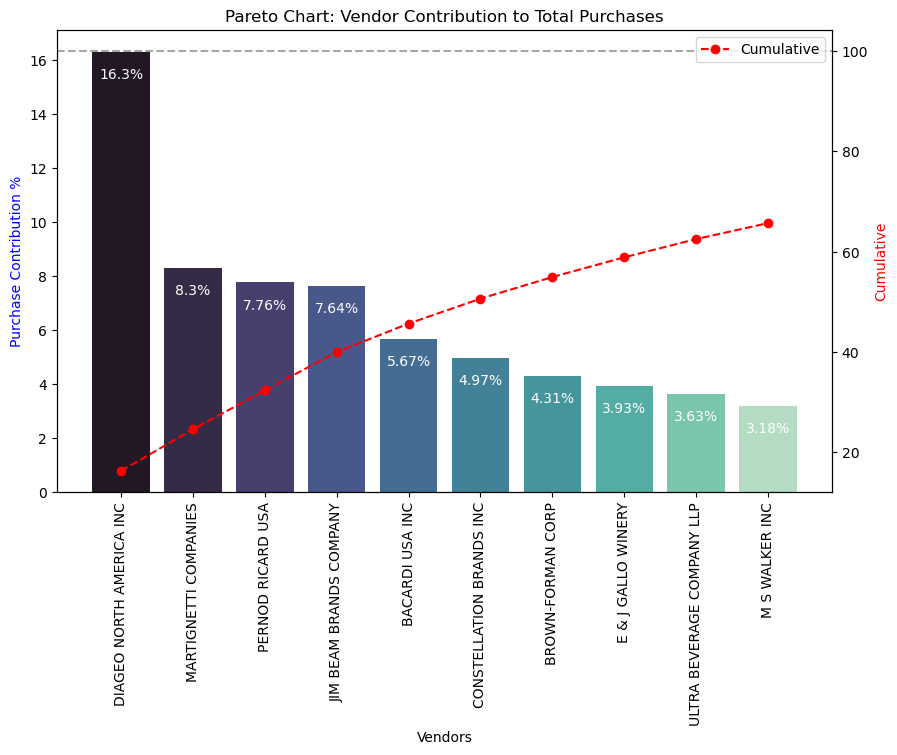

In [175]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Bar plot for Purchase Contribution %
sns.barplot(
    x=top_vendors['VendorName'],
    y=top_vendors['ContributionPurchase'],
    palette="mako",
    ax=ax1
)

# Add percentage labels on bars
for i, value in enumerate(top_vendors['ContributionPurchase']):
    ax1.text(
        i,
        value - 1,
        str(value) + '%',
        ha='center',
        fontsize=10,
        color='white'
    )

# Line plot for Cumulative
ax2 = ax1.twinx()
ax2.plot(
    top_vendors['VendorName'],
    top_vendors['Cumulative'],
    color='red',
    marker='o',
    linestyle='dashed',
    label='Cumulative'
)

# Axis labels and formatting
ax1.set_xticklabels(top_vendors['VendorName'], rotation=90)
ax1.set_ylabel('Purchase Contribution %', color='blue')
ax2.set_ylabel('Cumulative', color='red')
ax1.set_xlabel('Vendors')
ax1.set_title('Pareto Chart: Vendor Contribution to Total Purchases')

# Reference line at 100%
ax2.axhline(y=100, color='gray', linestyle='dashed', alpha=0.7)

ax2.legend(loc='upper right')
plt.show()


In [176]:
df['UnitPurchasePrice'] = df['TotalPurchaseDollars']/df["TotalPurchaseQuantity"]

In [180]:
df["OrderSize"] = pd.qcut(df['TotalPurchaseQuantity'], q=3, labels=['Small','Medium','Large'])
df

,VendorNumber,VendorName,Brand,description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,...,TotalSalesPrice,TotalExciseTax,FreightCost,Gross_Profit,%ProfitMargin,StockTurnover,SalesToPurchaseRatio,ContributionPurchase,UnitPurchasePrice,OrderSize
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,11522000.0,145080,3811251.60,142049.0,...,672819.31,260999.20,68601.68,1290667.91,25.297693,0.979108,1.338647,1.240082e+00,26.27,Large
1,4425,MARTIGNETTI COMPANIES,3405,Tito's Handmade Vodka,23.19,28.99,11385500.0,164038,3804041.22,160247.0,...,561512.37,294438.66,144929.24,1015032.27,21.062810,0.976890,1.266830,1.237736e+00,23.19,Large
2,17035,PERNOD RICARD USA,8068,Absolut 80 Proof,18.24,24.99,12878250.0,187407,3418303.68,187140.0,...,461140.15,343854.07,123780.22,1119816.92,24.675786,0.998575,1.327594,1.112227e+00,18.24,Large
3,3960,DIAGEO NORTH AMERICA INC,4261,Capt Morgan Spiced Rum,16.17,22.99,11854500.0,201682,3261197.94,200412.0,...,420050.01,368242.80,257032.07,1214774.94,27.139908,0.993703,1.372493,1.061109e+00,16.17,Large
4,3960,DIAGEO NORTH AMERICA INC,3545,Ketel One Vodka,21.89,29.99,11070500.0,138109,3023206.01,135838.0,...,545778.28,249587.83,257032.07,1199901.61,28.412764,0.983556,1.396897,9.836726e-01,21.89,Large
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8560,9815,WINE GROUP INC,8527,Concannon Glen Ellen Wh Zin,1.32,4.99,750.0,2,2.64,5.0,...,10.96,0.55,27100.41,13.31,83.448276,2.500000,6.041667,8.589873e-07,1.32,Small
8561,8004,SAZERAC CO INC,5683,Dr McGillicuddy's Apple Pie,0.39,0.49,50.0,6,2.34,134.0,...,1.47,7.04,50293.62,63.32,96.436186,22.333333,28.059829,7.613751e-07,0.39,Small
8562,3924,HEAVEN HILL DISTILLERIES,9123,Deep Eddy Vodka,0.74,0.99,50.0,2,1.48,2.0,...,0.99,0.10,14069.87,0.50,25.252525,1.000000,1.337838,4.815535e-07,0.74,Small
8563,3960,DIAGEO NORTH AMERICA INC,6127,The Club Strawbry Margarita,1.47,1.99,200.0,1,1.47,72.0,...,77.61,15.12,257032.07,141.81,98.974037,72.000000,97.469388,4.782998e-07,1.47,Small


In [182]:
df.groupby('OrderSize')['UnitPurchasePrice'].mean()

OrderSize
Small     39.057543
Medium    15.486414
Large     10.777625
Name: UnitPurchasePrice, dtype: float64

In [195]:
df[df['StockTurnover']<1].groupby('VendorName')['StockTurnover'].mean().sort_values(ascending=True).head(10)

VendorName
ALISA CARR BEVERAGES           0.615385
HIGHLAND WINE MERCHANTS LLC    0.708333
PARK STREET IMPORTS LLC        0.751306
Circa Wines                    0.755676
Dunn Wine Brokers              0.766022
CENTEUR IMPORTS LLC            0.773953
SMOKY QUARTZ DISTILLERY LLC    0.783835
TAMWORTH DISTILLING            0.797078
THE IMPORTED GRAPE LLC         0.807569
WALPOLE MTN VIEW WINERY        0.820548
Name: StockTurnover, dtype: float64

In [197]:
df.head(1)

,VendorNumber,VendorName,Brand,description,PurchasePrice,ActualPrice,Volume,TotalPurchaseQuantity,TotalPurchaseDollars,TotalSalesQuantity,...,TotalSalesPrice,TotalExciseTax,FreightCost,Gross_Profit,%ProfitMargin,StockTurnover,SalesToPurchaseRatio,ContributionPurchase,UnitPurchasePrice,OrderSize
0,1128,BROWN-FORMAN CORP,1233,Jack Daniels No 7 Black,26.27,36.99,11522000.0,145080,3811251.6,142049.0,...,672819.31,260999.2,68601.68,1290667.91,25.297693,0.979108,1.338647,1.240082,26.27,Large


In [211]:
df['unsold_inventory_value'] = df['PurchasePrice'] * (df['TotalPurchaseQuantity'] - df['TotalSalesQuantity'])

In [221]:
df.groupby('VendorName')['unsold_inventory_value'].sum().reset_index().sort_values(by='unsold_inventory_value',ascending=False).head(10)

,VendorName,unsold_inventory_value
25,DIAGEO NORTH AMERICA INC,722209.05
46,JIM BEAM BRANDS COMPANY,554665.63
68,PERNOD RICARD USA,470625.61
116,WILLIAM GRANT & SONS INC,401960.83
30,E & J GALLO WINERY,228282.61
79,SAZERAC CO INC,198436.41
11,BROWN-FORMAN CORP,177733.74
20,CONSTELLATION BRANDS INC,133617.62
61,MOET HENNESSY USA INC,126477.70
77,REMY COINTREAU USA INC,118598.15


In [223]:
top_threshold = df['TotalSalesDollars'].quantile(0.75)
low_threshold = df['TotalSalesDollars'].quantile(0.25)

In [228]:
top_vendor = df[df["TotalSalesDollars"] >= top_threshold]['%ProfitMargin'].dropna()
low_vendor = df[df["TotalSalesDollars"] <= low_threshold]['%ProfitMargin'].dropna()
low_vendor

5631     4.111764
5652     6.145626
5701    12.007271
5704     1.677308
5724     7.239599
          ...    
8560    83.448276
8561    96.436186
8562    25.252525
8563    98.974037
8564    99.166079
Name: %ProfitMargin, Length: 2142, dtype: float64

In [229]:
def confidence_interval(data, confidence=0.95):
    mean_val = np.mean(data)
    std_err = np.std(data, ddof=1) / np.sqrt(len(data))  # Standard error
    t_critical = stats.t.ppf((1 + confidence) / 2, df=len(data) - 1)
    margin_of_error = t_critical * std_err
    return mean_val, mean_val - margin_of_error, mean_val + margin_of_error


Top Vendors 95% CI: (30.74, 31.61), Mean: 31.17
Low Vendors 95% CI: (40.48, 42.62), Mean: 41.55


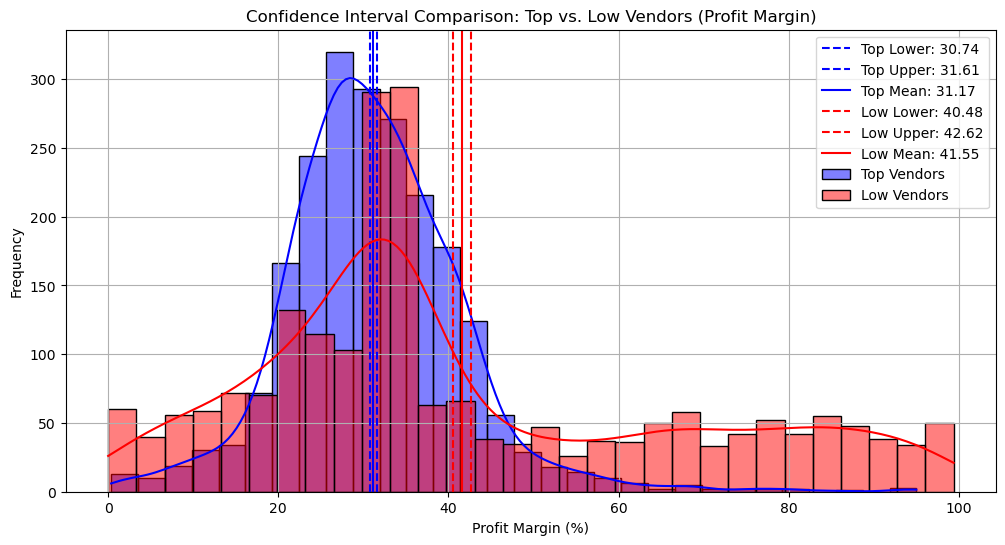

In [231]:
top_mean, top_lower, top_upper = confidence_interval(top_vendor)
low_mean, low_lower, low_upper = confidence_interval(low_vendor)

print(f"Top Vendors 95% CI: ({top_lower:.2f}, {top_upper:.2f}), Mean: {top_mean:.2f}")
print(f"Low Vendors 95% CI: ({low_lower:.2f}, {low_upper:.2f}), Mean: {low_mean:.2f}")

plt.figure(figsize=(12, 6))

# Top Vendors Plot
sns.histplot(top_vendor, kde=True, color="blue", bins=30, alpha=0.5, label="Top Vendors")
plt.axvline(top_lower, color="blue", linestyle="--", label=f"Top Lower: {top_lower:.2f}")
plt.axvline(top_upper, color="blue", linestyle="--", label=f"Top Upper: {top_upper:.2f}")
plt.axvline(top_mean, color="blue", linestyle="-", label=f"Top Mean: {top_mean:.2f}")

# Low Vendors Plot
sns.histplot(low_vendor, kde=True, color="red", bins=30, alpha=0.5, label="Low Vendors")
plt.axvline(low_lower, color="red", linestyle="--", label=f"Low Lower: {low_lower:.2f}")
plt.axvline(low_upper, color="red", linestyle="--", label=f"Low Upper: {low_upper:.2f}")
plt.axvline(low_mean, color="red", linestyle="-", label=f"Low Mean: {low_mean:.2f}")

# Finalize Plot
plt.title("Confidence Interval Comparison: Top vs. Low Vendors (Profit Margin)")
plt.xlabel("Profit Margin (%)")
plt.ylabel("Frequency")
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Null hypotheses: No difference between profit margins of top and low-performing vendors
# Alternate hypotheses: There is a difference between profit margins of top and low-performing vendors
top_threshold = df["TotalSalesDollars"].quantile(0.75)
low_threshold = df["TotalSalesDollars"].quantile(0.25)

top_vendors = df[df["TotalSalesDollars"] >= top_threshold]["%ProfitMargin"].dropna()
low_vendors = df[df["TotalSalesDollars"] <= low_threshold]["%ProfitMargin"].dropna()

# Perform Two-Sample T-Test
t_stat, p_value = ttest_ind(top_vendors, low_vendors, equal_var=False)

# Print results
print(f"T-Statistic: {t_stat:.4f}, P-Value: {p_value:.4f}")

if p_value < 0.05:
    print("Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.")
else:
    print("Fail to Reject H₀: No significant difference in profit margins.")


T-Statistic: -17.6440, P-Value: 0.0000
Reject H₀: There is a significant difference in profit margins between top and low-performing vendors.
